<a href="https://colab.research.google.com/github/Omar-Ouardighi/bluebook-bulldozer-price-regression/blob/main/bluebook_bulldozer_price_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚜 Predicting the Sale Price of Bulldozers using Machine Learning

In this notebook, we're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers.

Since we're trying to predict a number, this kind of problem is known as a regression problem.

The data and evaluation metric we'll be using (root mean square log error or RMSLE) is from [the Kaggle Bluebook for Bulldozers competition.](https://www.kaggle.com/c/bluebook-for-bulldozers/overview)


## Importing the data and preparing it for modelling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor



When working with time series data, it's a good idea to make sure any date data is the format of a datetime object.

In [2]:
df = pd.read_csv('TrainAndValid.csv', parse_dates=['saledate'], low_memory=False)
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,226,226,NaN,NaN,NaN,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,PC120-6E,PC120,NaN,-6E,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metr...",Texas,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,S175,S175,NaN,NaN,NaN,NaN,Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

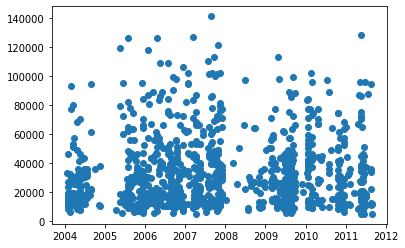

In [4]:
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000])

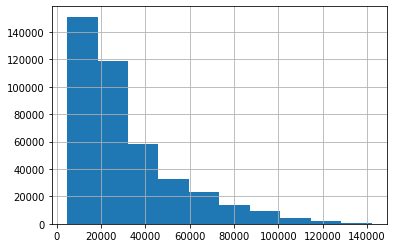

In [5]:
df.SalePrice.hist()


## Sort DataFrame by saledate

As we're working on a time series problem and trying to predict future examples given past examples, it makes sense to sort our data by date.


In [6]:
df.sort_values('saledate', inplace=True)
df.saledate.head(10)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
Name: saledate, dtype: datetime64[ns]


## Make a copy of the original DataFrame

Since we're going to be manipulating the data, we'll make a copy of the original DataFrame and perform our changes there.

This will keep the original DataFrame in tact if we need it again.


In [7]:
df_tmp = df.copy()

## Feature Engineering

In [8]:
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayofweek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayofyear"] = df_tmp.saledate.dt.dayofyear

# Drop original saledate
df_tmp.drop("saledate", axis=1, inplace=True)

df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,TD20,NaN,NaN,NaN,Medium,"Track Type Tractor, Dozer - 105.0 to 130.0 Hor...",Texas,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Direct Drive,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,A66,NaN,NaN,NaN,NaN,Wheel Loader - 120.0 to 135.0 Horsepower,Florida,WL,Wheel Loader,NaN,OROPS,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,D7,G,NaN,NaN,Large,"Track Type Tractor, Dozer - 190.0 to 260.0 Hor...",Florida,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,A62,NaN,NaN,NaN,NaN,Wheel Loader - Unidentified,Florida,WL,Wheel Loader,NaN,EROPS,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,D3,B,NaN,NaN,NaN,"Track Type Tractor, Dozer - 20.0 to 75.0 Horse...",Florida,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31


## Data Cleansing


In [9]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-nul

### Convert strings to categories

In [10]:
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype('category').cat.as_ordered()

df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

## Filling missing data
### Filling numerical values 

In [11]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

In [12]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            df_tmp[label] = content.fillna(content.median())

Check if we still have missing numerical data

In [13]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

### Filling and turning categorical variables to numbers

In [14]:
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        df_tmp[label] = pd.Categorical(content).codes + 1

In [15]:
df_tmp.isna().sum()

SalesID                     0
SalePrice                   0
MachineID                   0
ModelID                     0
datasource                  0
auctioneerID                0
YearMade                    0
MachineHoursCurrentMeter    0
UsageBand                   0
fiModelDesc                 0
fiBaseModel                 0
fiSecondaryDesc             0
fiModelSeries               0
fiModelDescriptor           0
ProductSize                 0
fiProductClassDesc          0
state                       0
ProductGroup                0
ProductGroupDesc            0
Drive_System                0
Enclosure                   0
Forks                       0
Pad_Type                    0
Ride_Control                0
Stick                       0
Transmission                0
Turbocharged                0
Blade_Extension             0
Blade_Width                 0
Enclosure_Type              0
Engine_Horsepower           0
Hydraulics                  0
Pushblock                   0
Ripper    

## Splitting data into train/valid sets
According to the Kaggle data page, the validation set and test set are split according to dates.

This makes sense since we're working on a time series problem.

E.g. using past events to try and predict future events.

Knowing this, randomly splitting our data into train and test sets using something like train_test_split() wouldn't work.

Instead, we split our data into training, validation and test sets using the date each sample occured.

In our case:

    Training = all samples up until 2011
    Valid = all samples form January 1, 2012 - April 30, 2012
    Test = all samples from May 1, 2012 - November 2012




In [16]:
df_tmp.saleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleYear, dtype: int64

In [17]:
df_valid = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_train), len(df_valid)

(401125, 11573)

In [18]:
X_train, y_train = df_train.drop('SalePrice', axis=1), df_train['SalePrice']
X_valid, y_valid = df_valid.drop('SalePrice', axis=1), df_valid['SalePrice']

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 56), (401125,), (11573, 56), (11573,))

In [19]:

def rmsle(y_test, y_preds):
    """
    Calculate Root Mean Square Log Error
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

In [20]:
%%time

model = XGBRegressor(random_state=42)

model.fit(X_train, y_train)

[09:25:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 1min 9s, sys: 349 ms, total: 1min 9s
Wall time: 1min 9s


In [21]:
y_pred = model.predict(X_valid)
y_pred

array([30561.867, 53270.023, 17555.16 , ..., 28791.814, 67173.914,
       31415.707], dtype=float32)

In [22]:
rmsle(y_valid, y_pred)

0.3730286897342659

### Hyperparameter Tuninig tuning with RandomizedSearchCV
I only tried 5 iter which wasn't enough to find the parameters so I WILL STICK with the basic model


In [23]:

params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [50,100, 200]}

xgbr = XGBRegressor(random_state = 42 )
rs_xgb = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         n_iter=5,
                         cv=3,
                         verbose=2)
rs_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] subsample=0.5, n_estimators=100, max_depth=6, learning_rate=0.3, colsample_bytree=0.7999999999999999, colsample_bylevel=0.4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[09:26:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  subsample=0.5, n_estimators=100, max_depth=6, learning_rate=0.3, colsample_bytree=0.7999999999999999, colsample_bylevel=0.4, total=  51.3s
[CV] subsample=0.5, n_estimators=100, max_depth=6, learning_rate=0.3, colsample_bytree=0.7999999999999999, colsample_bylevel=0.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   51.3s remaining:    0.0s


[09:27:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  subsample=0.5, n_estimators=100, max_depth=6, learning_rate=0.3, colsample_bytree=0.7999999999999999, colsample_bylevel=0.4, total=  49.8s
[CV] subsample=0.5, n_estimators=100, max_depth=6, learning_rate=0.3, colsample_bytree=0.7999999999999999, colsample_bylevel=0.4 
[09:28:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  subsample=0.5, n_estimators=100, max_depth=6, learning_rate=0.3, colsample_bytree=0.7999999999999999, colsample_bylevel=0.4, total=  50.2s
[CV] subsample=0.5, n_estimators=50, max_depth=6, learning_rate=0.01, colsample_bytree=0.8999999999999999, colsample_bylevel=0.6 
[09:29:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  subsample=0.5, n_estimators=50, max_depth=6, learning_rate=0.01

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 16.7min finished


[09:43:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=42, reg_alpha...
                   param_distributions={'colsample_bylevel': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'colsample_bytree': array([0.4, 0.5, 0.6, 0.7, 0

## Make predictions on test data

In [34]:
df_test = pd.read_csv('Test.csv', parse_dates=["saledate"] )
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,580,G,NaN,NaN,NaN,Backhoe Loader - 14.0 to 15.0 Ft Standard Digg...,Wyoming,BL,Backhoe Loaders,Two Wheel Drive,OROPS,Yes,None or Unspecified,No,Standard,Standard,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,936,NaN,NaN,NaN,Medium,Wheel Loader - 135.0 to 150.0 Horsepower,Virginia,WL,Wheel Loader,NaN,EROPS,Yes,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,20.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,EC210,B,NaN,LC,Large / Medium,"Hydraulic Excavator, Track - 21.0 to 24.0 Metr...",New Jersey,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,330,C,NaN,L,Large / Medium,"Hydraulic Excavator, Track - 33.0 to 40.0 Metr...",New Jersey,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,650,K,NaN,NaN,NaN,"Track Type Tractor, Dozer - 20.0 to 75.0 Horse...",Florida,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Hydrostatic,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


### Preprocessing the data 

In [35]:
def preprocess_data(df):
    # Add datetime parameters for saledate
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayofweek"] = df.saledate.dt.dayofweek
    df["saleDayofyear"] = df.saledate.dt.dayofyear

    # Drop original saledate
    df.drop("saledate", axis=1, inplace=True)
    
    # Fill numeric rows with the median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label] = content.fillna(content.median())
                
        # Turn categorical variables into numbers
        if not pd.api.types.is_numeric_dtype(content):
            # We add the +1 because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1        
    
    return df

In [36]:
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,25,0,0,0,2,51,1,1,4,3,2,2,1,2,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2012,5,3,3,124
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,0,0,0,4,57,46,6,6,0,1,2,0,2,0,0,0,0,0,0,0,1,0,0,0,0,7,3,0,0,0,0,0,0,0,0,0,0,0,0,3,2,2012,5,10,3,131
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,9,0,33,3,14,29,4,4,0,2,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,2,17,17,2,1,1,0,0,0,0,0,2012,5,10,3,131
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,13,0,32,3,18,29,4,4,0,2,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,3,0,0,0,2,17,20,2,2,2,0,0,0,0,0,2012,5,10,3,131
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,33,0,0,0,48,8,5,5,0,3,0,0,0,0,3,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,5,0,0,2012,5,10,3,131


In [37]:
test_pred = model.predict(df_test)
test_pred

array([22116.99 , 20586.484, 45069.938, ...,  9620.373, 24213.367,
       30568.857], dtype=float32)

In [38]:
# Create DataFrame compatible with Kaggle submission requirements
Submit = pd.DataFrame()
Submit["SalesID"] = df_test["SalesID"]
Submit["SalePrice"] = test_pred
Submit

,SalesID,SalePrice
0,1227829,22116.990234
1,1227844,20586.484375
2,1227847,45069.937500
3,1227848,63620.503906
4,1227863,40815.636719
...,...,...
12452,6643171,40020.273438
12453,6643173,18502.175781
12454,6643184,9620.373047
12455,6643186,24213.367188


In [39]:
Submit.to_csv('submit.csv', index=False)

## Feature Importance

In [42]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importance": importances})
          .sort_values("feature_importance", ascending=False)
          .reset_index(drop=True))
    
    sns.barplot(x="feature_importance",
                y="features",
                data=df[:n],
                orient="h")
    

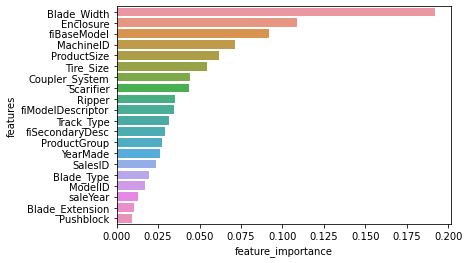

In [44]:
plot_features(X_train.columns, model.feature_importances_)